# **Common Test I. Multi-Class Classification**

**Note:** *Entire dataset training took more than 1 hour for 3 epochs and required more epochs for AUC score improvement. Which made difficult to analyze and optimize the model given the limited time to submit the GSoC test for evaluation. Hence 10% of dataset was used for training with 25 epochs, which took same 1 hour and achieved optimal evaluation metric score.*

*   Imports essential libraries for deep learning, image processing, and evaluation.
*   Handles datasets using PyTorch's Dataset and DataLoader.
*   Loads and processes images using PIL and torchvision.transforms.
*   Defines and trains neural networks using PyTorch (nn, optim, F).
*   Uses pretrained models from torchvision.models for tasks like classification.
*   Evaluates models using metrics like ROC-AUC and visualizations (Matplotlib).
*   Manages files and directories using os and glob.




In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import os
from glob import glob
from PIL import Image
from torchvision import models

Checks for *GPU* availability and sets the device accordingly.
Defines dataset paths for training and validation images across ***three classes (no, vort, sphere)***.
Creates a label mapping to convert class names into numerical labels for model training.

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset paths
train_dirs = {"no": "dataset/train/no/", "vort": "dataset/train/vort/", "sphere": "dataset/train/sphere/"}
valid_dirs = {"no": "dataset/val/no/", "vort": "dataset/val/vort/", "sphere": "dataset/val/sphere/"}

# Label mapping
label_map = {"no": 0, "vort": 1, "sphere": 2}

*   Defines a custom PyTorch dataset class (LensingDataset) for loading .npy image files.
*   Initializes dataset paths and labels, storing image file paths and corresponding labels.
*   Checks for missing .npy files and prints a warning if none are found.
*   Implements __len__ method to return the total number of samples.
*   Implements __getitem__ method to load an image, apply transformations (if any), and return it along with its label.











In [3]:
# Custom Dataset Class
class LensingDataset(Dataset):
    def __init__(self, directories, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []

        for label, path in directories.items():
            npy_files = glob(os.path.join(path, "*.npy"))
            if len(npy_files) == 0:
                print(f" Warning: No .npy files found in {path}")
            for img_path in npy_files:
                self.data.append(img_path)
                self.labels.append(label_map[label])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.load(self.data[idx]).astype(np.float32)  # Load image
        image = image.squeeze()  # Ensure shape is (H, W)

        label = self.labels[idx]  # Scalar class label

        if self.transform:
            image = self.transform(image)  # Convert to tensor (C, H, W)

        return image, label

Computes mean and standard deviation of the dataset for normalization.
Loads all .npy images, stacks them, and calculates dataset-wide mean and standard deviation.

> Defines a series of image transformations, including:
-  Conversion to PIL image (ToPILImage()).
-  Random affine transformations (rotation, translation, scaling).
-  Random horizontal flipping.
-  Random resized cropping.
-  Gaussian blur.
-  Conversion to tensor and normalization using computed mean and std.

In [4]:

# Transformations
from torchvision.transforms import ToPILImage
def compute_mean_std(dataset_dirs):
    all_data = []
    for label, path in dataset_dirs.items():
        npy_files = glob(os.path.join(path, "*.npy"))
        for img_path in npy_files:
            img = np.load(img_path).astype(np.float32)
            all_data.append(img)

    all_data = np.stack(all_data)  # Convert list to numpy array
    mean = np.mean(all_data) / 255.0
    std = np.std(all_data) / 255.0
    return mean, std

mean, std = compute_mean_std(train_dirs)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.2)),  # Resize after cropping
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])  # Normalization remains the same
])






*  Loads training and validation datasets using the LensingDataset class with transformations applied.
*  Creates a 10% subset of the training dataset by selecting random indices.
*  Initializes DataLoaders for both the subset (shuffled) and full validation set (not shuffled).
*  Counts class distributions in the full training, validation, and subset datasets using Counter.
*  Prints label distributions to check class balance in datasets.

In [5]:

# Load datasets
train_dataset = LensingDataset(train_dirs, transform=transform)
valid_dataset = LensingDataset(valid_dirs, transform=transform)

from torch.utils.data import Subset

# Get 10% of the training dataset
subset_size = int(0.1 * len(train_dataset))
indices = torch.randperm(len(train_dataset))[:subset_size]
train_subset = Subset(train_dataset, indices)

# Create DataLoader for the subset
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

from collections import Counter
train_label_counts = Counter(train_dataset.labels)
print("Training Set Label Counts:", train_label_counts)
valid_label_counts = Counter(valid_dataset.labels)
print("Validation Set Label Counts:", valid_label_counts)

# Get the label counts for the train_subset
train_subset_labels = [train_dataset[idx][1] for idx in indices]  # Get labels of the subset samples
train_subset_label_counts = Counter(train_subset_labels)
print("Training Subset Label Counts:", train_subset_label_counts)



Training Set Label Counts: Counter({0: 10000, 1: 10000, 2: 10000})
Validation Set Label Counts: Counter({0: 2500, 1: 2500, 2: 2500})
Training Subset Label Counts: Counter({1: 1019, 2: 1017, 0: 964})


*  Defines LensingResNet model based on ResNet-50, modifying the first layer for 1-channel input and the fully connected layer for 3 classes.
*  Initializes the model and moves it to the available device (GPU or CPU).
*  Defines loss function (CrossEntropyLoss) and optimizer (Adam with a learning rate of 0.0001).
*  Runs a training loop for 25 epochs, iterating over the dataset in batches.
*  Handles potential extra dimensions in images by squeezing if necessary.
*  Performs forward pass, computes loss, backpropagates gradients, and updates model parameters in each iteration.
*  Prints epoch-wise training loss to monitor model performance.

In [6]:
class LensingResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LensingResNet, self).__init__()
        self.base_model = models.resnet50(weights="IMAGENET1K_V1")
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for 1-channel
        self.base_model.fc = nn.Linear(2048, num_classes)  # Fix input dimension (2048, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Model initialization
model = LensingResNet(num_classes=3).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
epochs = 25

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # If there's an extra dimension, remove it
        if images.dim() == 5:
            images = images.squeeze(2)  # Remove the extra dimension

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/25, Loss: 1.1433
Epoch 2/25, Loss: 1.1231
Epoch 3/25, Loss: 1.1197
Epoch 4/25, Loss: 1.1041
Epoch 5/25, Loss: 1.1055
Epoch 6/25, Loss: 1.1043
Epoch 7/25, Loss: 1.0922
Epoch 8/25, Loss: 1.0845
Epoch 9/25, Loss: 1.0678
Epoch 10/25, Loss: 1.0450
Epoch 11/25, Loss: 1.0037
Epoch 12/25, Loss: 0.9570
Epoch 13/25, Loss: 0.9357
Epoch 14/25, Loss: 0.9072
Epoch 15/25, Loss: 0.8707
Epoch 16/25, Loss: 0.8426
Epoch 17/25, Loss: 0.8228
Epoch 18/25, Loss: 0.7906
Epoch 19/25, Loss: 0.7485
Epoch 20/25, Loss: 0.7279
Epoch 21/25, Loss: 0.7009
Epoch 22/25, Loss: 0.6647
Epoch 23/25, Loss: 0.6608
Epoch 24/25, Loss: 0.6374
Epoch 25/25, Loss: 0.6192


**Save Model Weights**

In [7]:
import torch
import json

# Get the state dictionary (model weights)
state_dict = model.state_dict()

# Convert tensors to lists for JSON serialization
state_dict_json = {key: value.tolist() for key, value in state_dict.items()}

# Save to a JSON file
with open("model_weights.json", "w") as json_file:
    json.dump(state_dict_json, json_file, indent=4)


**AUC-ROC Evaluation**

In [8]:

# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)

        # If there's an extra dimension, remove it
        if images.dim() == 5:
            images = images.squeeze(2)  # Remove the extra dimension

        outputs = model(images)
        preds = torch.softmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Compute AUC-ROC
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
auc = roc_auc_score(np.eye(3)[all_labels], all_preds, multi_class='ovr')
print(f"Validation AUC-ROC: {auc:.4f}")


Validation AUC-ROC: 0.8846


**AUC-ROC Plotting**

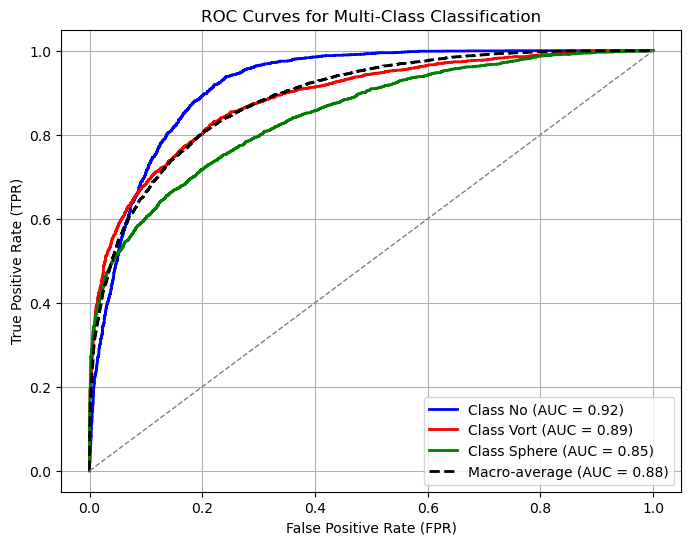

In [9]:
# Compute ROC curve and AUC for each class
num_classes = 3
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(num_classes)[all_labels][:, i], all_preds[:, i])
    roc_auc[i] = roc_auc_score(np.eye(num_classes)[all_labels][:, i], all_preds[:, i])

# Compute macro-average ROC curve and AUC
fpr["macro"], tpr["macro"], _ = roc_curve(np.eye(num_classes)[all_labels].ravel(), all_preds.ravel())
roc_auc["macro"] = roc_auc_score(np.eye(num_classes)[all_labels], all_preds, multi_class='ovr')

# Plot the ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
class_labels = ['No', 'Vort', 'Sphere']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--', lw=2, label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})')

# Plot random classifier line (diagonal)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()
